## Задача проекта
Необходимо разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке коров. «ЭкоФерма» предоставляет подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
С помощью модели нужно отобрать коров по двум критериям:
средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.


#### 0. Необходимые импорты

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline


#### Подготовка данных
- получение из файлов csv
- обзор данных
- оценка типов 

In [ ]:
df1 = pd.read_csv('datasets/ferma_main.csv', sep=';')
df2 = pd.read_csv('datasets/ferma_dad.csv', sep=';')
df3 = pd.read_csv('datasets/cow_buy.csv', sep=';')

В числовых данных  обнаружены запятые в качестве десятичных разделителей.
Исправлено в df1, df3.

In [ ]:

# Замена запятых в числах на точки
list_to_make_float_1 = ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']
list_to_make_float_2 = ['Текущая_жирность,%', 'Текущий_уровень_белок,%']
df1[list_to_make_float_1] = df1[list_to_make_float_1].apply(lambda x: x.str.replace(',', '.').astype(float)) 
df3[list_to_make_float_2] = df3[list_to_make_float_2].apply(lambda x: x.str.replace(',', '.').astype(float)) 

In [ ]:
# Данные фермы
display(df1.info())
display(df1.head())

In [ ]:
# Данные по папам - быкам
display(df2.info())
display(df2.head())

In [ ]:
# Данные о предполагаемых покупках
display(df3.info())
display(df3.head())

#### Предобработка данных


Поиск и удаление полных дубликатов

In [ ]:
# Удаление полных дубликатов.
display("до удаления", df1.duplicated().sum())
df1.drop_duplicates(inplace=True)
display("после удаления", df1.duplicated().sum())

Поиск и удаление пропущенных значений

In [ ]:
# поиск пропущенных
display(df1.isna().sum())

Пропущенных не наблюдается

### 2. Исследовательский анализ данных

In [ ]:
# Построение диаграмм для признаков
# Строим графики для каждой числовой переменной
numeric_columns = [
    'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г',
                   'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%'
]
ranges = [(5000, 7000), (10, 17), (1500, 2500), (0.8, 1.0), (2.8, 4), (3.05, 3.1)]
for ind, col in enumerate(numeric_columns):
    plt.figure(figsize=(3, 3))  # Создаем новую фигуру для каждого графика
    plt.hist(df1[col], bins=50, range=ranges[ind])  # Гистограмма для числовых данных
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

Гистограммы похожи на "гребёнку". Скорее всего разные данные распределяются по разным критериям - папам, лугам, возрасту и т.д.

Графики для категориальных столбцов

In [ ]:
# Категориальные признаки
categorical_columns = df1.select_dtypes(include=['object']).columns

# Строим графики для каждой категориальной переменной
for col in categorical_columns:
    plt.figure(figsize=(3, 3))  # Создаем новую фигуру для каждого графика
    sns.countplot(x=col, data=df1)  # Бар-диаграмма для категориальных данных
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

#### Корреляционный анализ

In [ ]:
# Матрица корреляции
display(df1[numeric_columns].corr())

сильно коррелируют СПО и жирность с ЭКЕ

In [ ]:
# Строим график зависимости удоя от количественных переменных

# Используем hue для окрашивания точек по категориям
for ind, col in enumerate(numeric_columns[1:], 1):
    plt.figure(figsize=(5, 5))
    
    # Передаем категориальную колонку в hue
    sns.scatterplot(x=df1[col], y=df1['Удой, кг'], hue=df1[categorical_columns[ind - 1]])
    
    plt.title(f'Зависимость удоя от {col}')
    plt.xlabel(col)
    plt.xlim([ranges[ind][0], ranges[ind][1]])  # Ограничение по оси x
    plt.ylabel('Удой, кг')
    plt.ylim([4000, 7000])  # Ограничение по оси y
    plt.grid()
    plt.legend(title='Категория')  # Легенда для категорий
    plt.show()

Молодые коровы дают меньше молока.

#### Задача регрессии

Целевой признак - Удой, в качестве входных признаков возьмём ЭКЕ, так как он имеет наиболее ярко выраженную линейную зависимость и свойства молока: белок, жирность - как необходимые качественные показатели. В качестве категориальных признаков возьмем возраст и породу. По ним наиболее резкие разделения по большинству закономерностей.

РАзбиваем данные на тестовую и тренировочную выборки.

In [ ]:
# набор столбцов для анализа
columns_to_use = [
    'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
    'Жирность,%', 'Белок,%', 'порода папы_быка', 'Возраст',
] 
df_1_1 = df1[columns_to_use]
df_1_1.head()

# Выделяем входные данные (Х)
X = df_1_1.drop('Удой, кг', axis=1)
X.head()

# Выделяем выходные данные (Y)
y = df_1_1['Удой, кг']
y.head()


In [ ]:
# Разделяем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    # test_size=0.2,
    random_state=42)


Масштабирование признаков

In [ ]:
# Категориальные данные
categorical_cols = ['порода папы_быка', 'Возраст']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train_ohe = encoder.fit_transform(X_train[categorical_cols])
X_test_ohe = encoder.transform(X_test[categorical_cols])

Объединяем данные для обучения модели.

In [ ]:
# Количественные признаки
numerical_cols = ['ЭКЕ (Энергетическая кормовая единица)', 'Жирность,%', 'Белок,%']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

In [ ]:
# Преобразуем масштабированные числовые признаки в sparse матрицу
from scipy.sparse import csr_matrix
X_train_scaled_sparse = csr_matrix(X_train_scaled)
X_test_scaled_sparse = csr_matrix(X_test_scaled)

# Объединяем по горизонтали
X_train_final = hstack([X_train_scaled_sparse, X_train_ohe])
X_test_final = hstack([X_test_scaled_sparse, X_test_ohe])

#### Обучаем модель линейной регрессии

In [ ]:
# Модель.

model_lr = LinearRegression()
model_lr.fit(X_train_final, y_train)

# Прогноз.

y_pred = model_lr.predict(X_test_final)
y_pred

# Оценка.

model_lr.score(X_test_final, y_test)

Рассчитаем R<sup>2</sup>

In [ ]:
# Расчёт
r2 = r2_score(y_test, y_pred)
print(r2)

In [ ]:
# анализ остатков
residuals = residuals = y_test - y_pred

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

#### Вторая модель

Преобразование СПО в категориальный признак по разделению данных на 2 кластера. Граничное значение СПО - 0.91 (среднее между максимальным значением одного кластера и минимальным другого)

In [ ]:
boundary = 0.91  # Примерное значение

df1['СПО_категория'] = (df1['СПО (Сахаро-протеиновое соотношение)'] >= boundary).astype(int)

# Категориальные столбцы (включая новый СПО_категория)
categorical_cols_2 = [
    'Порода', 'Тип пастбища', 'порода папы_быка',
    'Вкус молока', 'Возраст', 'СПО_категория'
]

# Удаляем исходный СПО и добавляем категориальный
X = df1.drop(['СПО (Сахаро-протеиновое соотношение)', 'Удой, кг', 'id'], axis=1)
y = df1['Удой, кг']

Устранение нелинейности зависимости Удой от ЭКЕ

In [ ]:
# Добавление столбца с квадратом значения
df1['ЭКЕ_2'] = df1['ЭКЕ (Энергетическая кормовая единица)'] ** 2

# обновление столбцов с количественными признаками
numeric_cols_2 = [ 
    'ЭКЕ_2',
    'Сырой протеин, г', 
    'Жирность,%', 
    'Белок,%'
]

In [ ]:
# Новое разделение на train/test
X = df1.drop(
    [
        'Удой, кг', 'id',
        'СПО (Сахаро-протеиновое соотношение)',
        'ЭКЕ (Энергетическая кормовая единица)',
        ], axis=1
)
y = df1['Удой, кг']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Подготовка данных для второй модели

In [ ]:
# Категориальные данные
categorical_cols_2 = ['порода папы_быка', 'Возраст']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train_ohe_m2 = encoder.fit_transform(X_train[categorical_cols_2])
X_test_ohe_m2 = encoder.transform(X_test[categorical_cols_2])

In [ ]:
# Количественные дaнные
X_train_scaled_m2 = scaler.fit_transform(X_train[numeric_cols_2])
X_test_scaled_m2 = scaler.transform(X_test[numeric_cols_2])

In [ ]:
# Преобразуем масштабированные числовые признаки в sparse матрицу
from scipy.sparse import csr_matrix
X_train_scaled_sparse = csr_matrix(X_train_scaled_m2)
X_test_scaled_sparse = csr_matrix(X_test_scaled_m2)

# Объединяем по горизонтали
X_train_final_m2 = hstack([X_train_scaled_sparse, X_train_ohe_m2])
X_test_final_m2 = hstack([X_test_scaled_sparse, X_test_ohe_m2])

Обучаем вторую модель

In [ ]:
# Модель.

model_lr_2 = LinearRegression()
model_lr_2.fit(X_train_final_m2, y_train)

# Прогноз.

y_pred_2 = model_lr_2.predict(X_test_final_m2)
y_pred_2

# Оценка.

model_lr_2.score(X_test_final_m2, y_test)

Расчёт R<sup>2</sup>  для второй модели

In [ ]:
# Расчёт
r2 = r2_score(y_test, y_pred_2)
print(r2)

In [ ]:
# Расчёт
r2 = r2_score(y_test, y_pred_2)
print(r2)

In [ ]:
# анализ остатков
residuals = residuals = y_test - y_pred_2

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_2, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Выводы

#### Третья модель

In [108]:
# Объединяем по столбцу 'id'
df_merged = pd.merge(
    df1, 
    df2, 
    on='id', 
    how='left'
)
df_merged.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,СПО_категория,ЭКЕ_2,Имя Папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


In [109]:
# Обновляем список категориальных признаков
categorical_cols_3 = [
    'Порода', 
    'Тип пастбища', 
    'порода папы_быка', 
    'Вкус молока', 
    'Возраст',
    'СПО_категория',
    'Имя Папы'
]


Построим диаграмму для визуального анализа

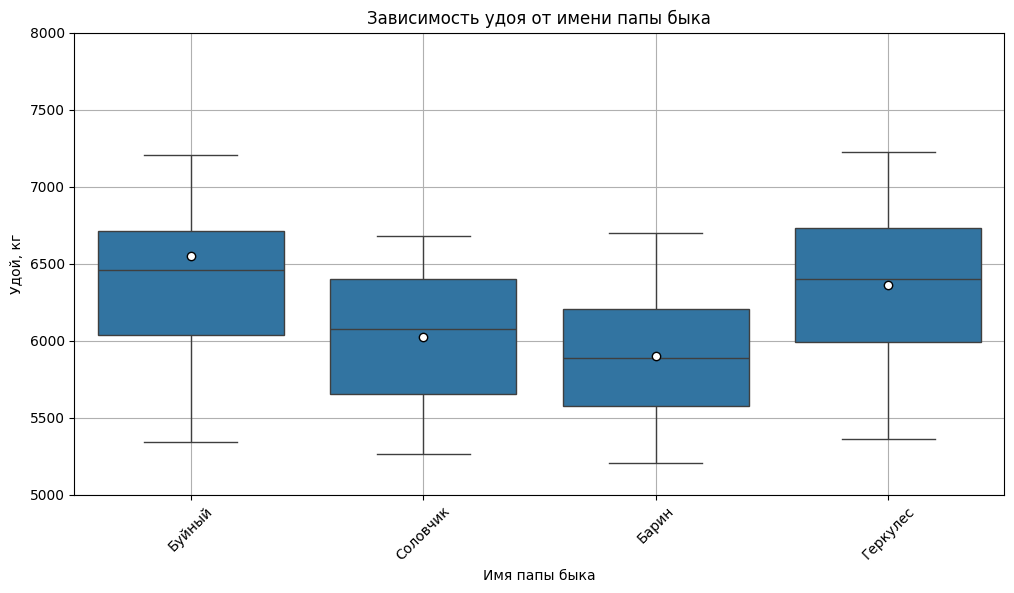

In [106]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_merged, 
    x='Имя Папы', 
    y='Удой, кг',
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'}
)
plt.ylim(5000, 8000)  # Устанавливаем ограничения на оси y
plt.xticks(rotation=45)  # Поворачиваем подписи для читаемости
plt.title('Зависимость удоя от имени папы быка')
plt.xlabel('Имя папы быка')
plt.ylabel('Удой, кг')
plt.grid(True)
plt.show()

Преобразование нового признака

In [ ]:
# ????
mean_yield = df_merged.groupby('Имя Папы')['Удой, кг'].mean().to_dict()
df_merged['Имя_Папы_encoded'] = df_merged['Имя Папы'].map(mean_yield)

In [113]:
# Обновление списка колонок
numerical_cols = [
    'ЭКЕ (Энергетическая кормовая единица)', 
    'ЭКЕ²', 
    'Сырой протеин, г', 
    'Жирность,%', 
    'Белок,%',
    'Имя_Папы_encoded'  # Новый числовой признак
]